# Importing Required Libraries

In [69]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk, re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Read Data

In [47]:
train = pd.read_csv('Desktop/fake-news/train.csv')
test = pd.read_csv('Desktop/fake-news/test.csv')

# Analyze Data

In [48]:
print(train.shape, test.shape)

(20800, 5) (5200, 4)


# Check Null Values

In [49]:
print("\n\nNull Values: \nTrain Data:\n")
print(train.isnull().sum())
print("\n\nTest Data:\n")
print(test.isnull().sum())



Null Values: 
Train Data:

id           0
title      558
author    1957
text        39
label        0
dtype: int64


Test Data:

id          0
title     122
author    503
text        7
dtype: int64


# Removing Null Values

In [50]:
train = train.fillna(' ')
test = test.fillna(' ')

# Creating WordCloud

In [51]:
train['total'] = train['title'] + ' ' + train['author'] + train['text']
test['total'] = test['title'] + ' ' + test['author'] + test['text']

In [52]:
print(train['total'].head, test['total'].head)

<bound method NDFrame.head of 0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        FLYNN: Hillary Clinton, Big Woman on Campus - ...
2        Why the Truth Might Get You Fired Consortiumne...
3        15 Civilians Killed In Single US Airstrike Hav...
4        Iranian woman jailed for fictional unpublished...
5        Jackie Mason: Hollywood Would Love Trump if He...
6        Life: Life Of Luxury: Elton John’s 6 Favorite ...
7        Benoît Hamon Wins French Socialist Party’s Pre...
8        Excerpts From a Draft Script for Donald Trump’...
9        A Back-Channel Plan for Ukraine and Russia, Co...
10       Obama’s Organizing for Action Partners with So...
11       BBC Comedy Sketch "Real Housewives of ISIS" Ca...
12       Russian Researchers Discover Secret Nazi Milit...
13       US Officials See No Link Between Trump and Rus...
14       Re: Yes, There Are Paid Government Trolls On S...
15       In Major League Soccer, Argentines Find a Home...
16       Wells Fargo Chief

In [53]:
real_words = ''
fake_words = ''
stopwords = set(STOPWORDS)
tokens = ''

In [54]:
test.head()

,id,title,author,text,total
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995) Truth Broadcas...


In [55]:
for i in train[train['label']==1].total:
    tokens = i.split()
    
    for j in range(len(tokens)):
        
        tokens[j] = tokens[j].lower()
    
    real_words += " ".join(tokens)+" "
    
for i in train[train['label']==0].total:
    tokens = i.split()
    
    for j in range(len(tokens)):
        
        tokens[j] = tokens[j].lower()
        
    fake_words += " ".join(tokens)+" "

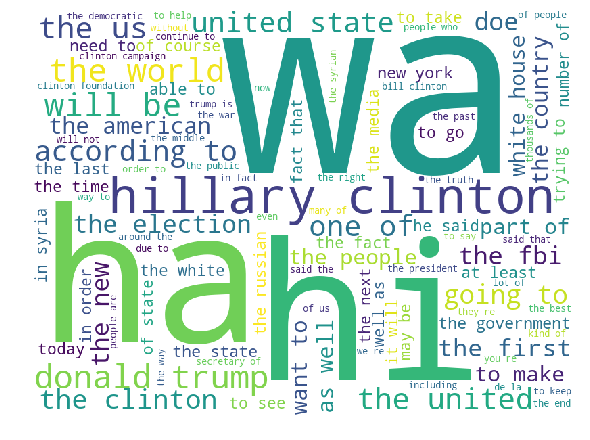

In [57]:

wordcloud = WordCloud(width = 800, height = 600,
                      background_color = 'white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(real_words)

plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Cleaning and Pre Processing

In [70]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
# iterate over dataframe rows.
for index, row in train.iterrows():
    
    filter_sentence = ''
    
    sentence = row['total']
    
    # remove all the characters except words and spaces.
    sentence = re.sub(r'[^\w\s]', '', sentence)
    
    
    # tokenize the row
    words = nltk.word_tokenize(sentence)
    
    # remove stop words
    words = [w for w in words if not w in stop_words]
    
    #store lemmatized words in lower case
    for word in words:
        
        filter_sentence = filter_sentence + ' ' + str(lemmatizer.lemmatize(word)).lower()
    
    #replace row with clean data
    train.loc[index, 'total'] = filter_sentence
    
    

In [72]:
train = train[['total', 'label']]

# Applying NLP Techniques

In [73]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [98]:
X_train = train['total']
Y_train = train['label']

In [77]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X_train)
freq_term_matrix = count_vectorizer.transform(X_train)
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [79]:
tf_idf_matrix.shape

(20800, 220387)

# Modelling

In [83]:
test_counts = count_vectorizer.transform(test['total'].values)
test_tfidf = tfidf.transform(test_counts)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, Y_train, random_state = 0)

In [84]:
X_train.shape

(15600, 220387)

# Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
print('Accuracy of Logistic classifier on training data: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic classifier on testing data: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic classifier on training data: 1.00
Accuracy of Logistic classifier on testing data: 0.98


In [90]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[2494,   70],
       [  45, 2591]], dtype=int64)

# MultinomialNB

In [91]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)
pred = NB.predict(X_test)
print('Accuracy of NB  classifier on training set: {:.2f}'
     .format(NB.score(X_train, y_train)))
print('Accuracy of NB classifier on test set: {:.2f}'
     .format(NB.score(X_test, y_test)))
cm = confusion_matrix(y_test, pred)
cm

Accuracy of NB  classifier on training set: 0.88
Accuracy of NB classifier on test set: 0.83


array([[2558,    6],
       [ 853, 1783]], dtype=int64)

# Deployment Pipeline

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn import linear_model

In [100]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', linear_model.LogisticRegression(C=1e5)),
])

In [101]:
X_train = train['total']
Y_train = train['label']
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [102]:
filename = 'pipeline.sav'
joblib.dump(pipeline, filename)

['pipeline.sav']

# Prediction

In [103]:
loaded_model = joblib.load(filename)
result = loaded_model.predict(["flynn hillary clinton big woman campus breitbart daniel j flynnever get feeling life circle roundabout rather head straight line toward intended destination hillary clinton remains big woman campus leafy liberal wellesley massachusetts everywhere else vote likely inauguration dress remainder day way miss havisham forever wore wedding dress speaking great expectations hillary rodham overflowed 48 year ago first addressed wellesley graduating class the president college informed gathered 1969 student needed debate far i could ascertain spokesman kind like democratic primary 2016 minus term unknown even seven sisters school i glad miss adams made clear i speaking today u 400 u miss rodham told classmate after appointing edger bergen charlie mccarthys mortimer snerds attendance bespectacled granny glass awarding matronly wisdom least john lennon wisdom took issue previous speaker despite becoming first win election seat u s senate since reconstruction edward brooke came criticism calling empathy goal protestors criticized tactic though clinton senior thesis saul alinsky lamented black power demagogue elitist arrogance repressive intolerance within new left similar word coming republican necessitated brief rebuttal trust rodham ironically observed 1969 one word i asked class rehearsal wanted say everyone came said talk trust talk lack trust u way feel others talk trust bust what say what say feeling permeates generation perhaps even understood distrusted the trust bust certainly busted clintons 2016 plan she certainly even understand people distrusted after whitewater travelgate vast conspiracy benghazi missing email clinton found distrusted voice friday there load compromising road broadening political horizon and distrust american people trump edged 48 percent 38 percent question immediately prior novembers election stood major reason closing horizon clinton described vanquisher supporter embracing lie con alternative fact assault truth reason she failed explain american people chose lie truth as history major among today know well people power invent fact attack question mark beginning end free society offered that hyperbole like many people emerge 1960s hillary clinton embarked upon long strange trip from high school goldwater girl wellesley college republican president democratic politician clinton drank time place gave degree more significantly went idealist cynic comparison two wellesley commencement address show way back lamented long leader viewed politics art possible challenge practice politics art making appears impossible possible now big woman campus odd woman white house wonder current station even possible why arent i 50 point ahead asked september in may asks isnt president the woman famously dubbed congenital liar bill safire concludes lie mind getting stood election day like finding jilted bride wedding day inspires dangerous delusion"])
print(result) 

[0]
